# The below code is inspired from the work done by a kaggle user "Keita Kurita". 

* The idea is to generate a fastai based databunch which will be used to finally fine tune a bert model

In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
from typing import *

import torch
import torch.optim as optim

In [2]:
from fastai import *
from fastai.vision import *
from fastai.text import *
from fastai.callbacks import *

In [3]:
!pip install pytorch-pretrained-bert

In [69]:
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)

config = Config(
    bert_model_name="bert-base-uncased",
    max_lr=3e-5,
    epochs=10,
    use_fp16=True,
    bs=32,
    discriminative=False,
    max_seq_len=256,
)

In [5]:
from pytorch_pretrained_bert import BertTokenizer
bert_tok = BertTokenizer.from_pretrained(
    config.bert_model_name,
)

100%|██████████| 231508/231508 [00:00<00:00, 5762186.93B/s]


In [6]:
def _join_texts(texts:Collection[str], mark_fields:bool=False, sos_token:Optional[str]=BOS):
    """Borrowed from fast.ai source"""
    if not isinstance(texts, np.ndarray): texts = np.array(texts)
    if is1d(texts): texts = texts[:,None]
    df = pd.DataFrame({i:texts[:,i] for i in range(texts.shape[1])})
    text_col = f'{FLD} {1} ' + df[0].astype(str) if mark_fields else df[0].astype(str)
    if sos_token is not None: text_col = f"{sos_token} " + text_col
    for i in range(1,len(df.columns)):
        #text_col += (f' {FLD} {i+1} ' if mark_fields else ' ') + df[i]
        text_col += (f' {FLD} {i+1} ' if mark_fields else ' ') + df[i].astype(str)
    return text_col.values

In [7]:
class FastAiBertTokenizer(BaseTokenizer):
    """Wrapper around BertTokenizer to be compatible with fast.ai"""
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length"""
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

In [94]:
from sklearn.model_selection import train_test_split

DATA_ROOT = Path("..") / "input" / "sentiment"

train, test = [pd.read_excel(DATA_ROOT / fname) for fname in ["Data_Train.xlsx", "Data_Test.xlsx"]]
val = train
print(train.shape, val.shape)

(7628, 2) (7628, 2)


In [96]:
fastai_bert_vocab = Vocab(list(bert_tok.vocab.keys()))

In [97]:
fastai_tokenizer = Tokenizer(tok_func=FastAiBertTokenizer(bert_tok, max_seq_len=config.max_seq_len), pre_rules=[], post_rules=[])

In [98]:
train.head()

,STORY,SECTION
0,But the most painful was the huge reversal in ...,3
1,How formidable is the opposition alliance amon...,0
2,Most Asian currencies were trading lower today...,3
3,"If you want to answer any question, click on ‘...",1
4,"In global markets, gold prices edged up today ...",3


In [99]:
train = pd.get_dummies(train, columns=['SECTION'])
val = pd.get_dummies(val, columns=['SECTION'])

In [101]:
label_cols = ['SECTION_0', 'SECTION_1', 'SECTION_2', 'SECTION_3']

In [102]:
class BertTokenizeProcessor(TokenizeProcessor):
    def __init__(self, tokenizer):
        super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False)

class BertNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, vocab=Vocab(list(bert_tok.vocab.keys())), **kwargs)

def get_bert_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    return [BertTokenizeProcessor(tokenizer=tokenizer),
            NumericalizeProcessor(vocab=vocab)]

In [103]:
class BertDataBunch(TextDataBunch):
    @classmethod
    def from_df(cls, path:PathOrStr, train_df:DataFrame, valid_df:DataFrame, test_df:Optional[DataFrame]=None,
                tokenizer:Tokenizer=None, vocab:Vocab=None, classes:Collection[str]=None, text_cols:IntsOrStrs=1,
                label_cols:IntsOrStrs=0, label_delim:str=None, **kwargs) -> DataBunch:
        "Create a `TextDataBunch` from DataFrames."
        p_kwargs, kwargs = split_kwargs_by_func(kwargs, get_bert_processor)
        # use our custom processors while taking tokenizer and vocab as kwargs
        processor = get_bert_processor(tokenizer=tokenizer, vocab=vocab, **p_kwargs)
        if classes is None and is_listy(label_cols) and len(label_cols) > 1: classes = label_cols
        src = ItemLists(path, TextList.from_df(train_df, path, cols=text_cols, processor=processor),
                        TextList.from_df(valid_df, path, cols=text_cols, processor=processor))
        src = src.label_for_lm() if cls==TextLMDataBunch else src.label_from_df(cols=label_cols, classes=classes)
        if test_df is not None: src.add_test(TextList.from_df(test_df, path, cols=text_cols))
        return src.databunch(**kwargs)

In [104]:
databunch = BertDataBunch.from_df(".", train, val, test,
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_bert_vocab,
                  text_cols="STORY",
                  label_cols=label_cols,
                  bs=config.bs,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )

# Model

In [105]:
from pytorch_pretrained_bert.modeling import BertConfig, BertForSequenceClassification
bert_model = BertForSequenceClassification.from_pretrained(config.bert_model_name, num_labels=4)

In [106]:
loss_func = nn.BCEWithLogitsLoss()

In [107]:
from fastai.callbacks import *

learner = Learner(
    databunch, bert_model,
    loss_func=loss_func,
)
if config.use_fp16: learner = learner.to_fp16()

In [108]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


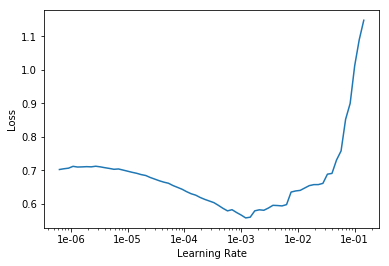

In [109]:
learner.recorder.plot()

In [110]:
learner.fit_one_cycle(config.epochs, max_lr=config.max_lr)

epoch,train_loss,valid_loss,time
0,0.395028,0.267539,02:13
1,0.099129,0.047389,02:18
2,0.037288,0.025490,02:17
3,0.023574,0.016976,02:18
4,0.025166,0.009883,02:27
5,0.016545,0.006756,02:19
6,0.009579,0.005723,02:25
7,0.006136,0.004856,02:27
8,0.006793,0.004263,02:33
9,0.006496,0.004238,02:40


In [111]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

In [112]:
val_preds = get_preds_as_nparray(DatasetType.Valid)

In [113]:
y_valid = np.argmax(val[label_cols].values, axis=1)

In [114]:
from sklearn.metrics import accuracy_score
accuracy_score(y_valid, np.argmax(val_preds, axis=1))

0.9972469847928683

In [115]:
test_preds = get_preds_as_nparray(DatasetType.Test)

In [116]:
np.save("model_bert_base_prob.npy", test_preds)

In [117]:
test_outcome = np.argmax(test_preds, axis=1)

In [118]:
sample_submission = pd.read_excel(DATA_ROOT / "Sample_submission.xlsx", index_col=None)
sample_submission['SECTION'] = test_outcome
print(pd.Series(test_outcome).value_counts())
sample_submission.to_excel("model_bert_base.xlsx", index=False)

1    1183
2     822
0     422
3     321
dtype: int64
